# TP Large Scale Kernel Methods

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from math import pi, sqrt, cos

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file
import warnings
warnings.filterwarnings("ignore")

## Chargement et partitionnement des données

In [15]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [22]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from time import time

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = SVC(kernel='rbf') 
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
# TODO
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
accuracy_kernel = accuracy_score(y_test, y_pred)
print("classification accuracy: %0.3f" % accuracy_kernel)

########################################## TODO same for LinearSVC ##########################################
print("\n")
print("Fitting LinearSVC on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = LinearSVC(dual=False) 
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with LinearSVC on %d samples..." % X_test.shape[0])
t1 = time()
# TODO
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t1))
timing_linear = time() - t0
accuracy_linear = accuracy_score(y_test, y_pred)
print("classification accuracy: %0.3f" % accuracy_linear)

Fitting SVC rbf on 20000 samples...
done in 4.714s
Predicting with SVC rbf on 40000 samples...
done in 5.417s
classification accuracy: 0.980


Fitting LinearSVC on 20000 samples...
done in 0.095s
Predicting with LinearSVC on 40000 samples...
done in 0.002s
classification accuracy: 0.917


* Le LinearSVC est beaucoup plus rapide mais obtient un moins bon score que le SVC rbf (noyau gaussien).
* Ici le problème est dual. Les données se prettent mieux à un apprentissage SVM avec noyau. Le séparateur hyperplan pourra mieux séparer les données

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [17]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd


def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u, s, vt = svds(gram_mat, k)
        gram_mat_k = np.dot(np.dot(u, np.diag(s)), vt)
        # TODO
    else:
        u, s, vt = svd(gram_mat)
        gram_mat_k = np.dot(np.dot(u[::, :k], np.diag(s[:k])), vt[:k, ::])
        # TODO
    return gram_mat_k

## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [18]:
from numpy.linalg import norm

p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    #print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # TODO: compute relative error with Frobenius norm
    rel_error[k] = norm(gram_mat_k - gram_signal, ord='fro') / norm(gram_signal, ord='fro')

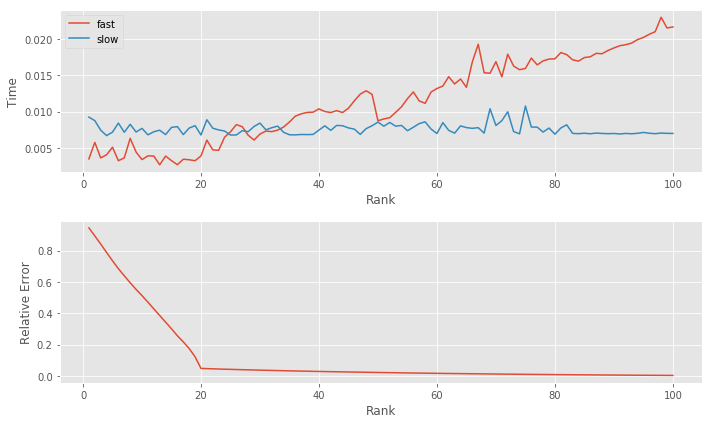

In [20]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

** Pour la méthode lente, nous effectuons toujours le même calcul de matrice, puis fixons le nombre d'éléments que nous souhaitons conserver. Il paraît donc logique que le temps d'exécution reste sensiblement le même peu importe le rang fixé pour cette méthode. En revanche, la méthode rapide l'est effectivement au début puisqu'elle effctue un calcul sur des matrices plus petites dans un premier temps. Cependant, passé le rang k=23, elle devient plus lente. **

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [7]:
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    W = np.sqrt(2 * gamma) * rng.randn(n_features, c)
    b = np.random.random_integers(2 * pi, c)
    X_new_train = sqrt(2 / c) * np.cos(np.dot(X_train, W) + b)
    X_new_test = sqrt(2 / c) * np.cos(np.dot(X_test, W) + b)

    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [8]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)

Fitting SVC linear on 20000 samples...
done in 1.314s
Predicting with SVC linear on 40000 samples...
done in 0.017s
classification accuracy: 0.963


** Nous pouvons constater qu'avec l'utilisation de la méthode Random Kernel Features le temps de calcul est plus important. Cependant nous gagnons en précision puisque nous passons d'une précision de 91.7% à 96.3%**

## Question 6

On implémente la méthode de Nystrom.

In [9]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    X_test_idx = X_test[idx, :]

    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    u, s, vt = svd(W)
    Wk = np.dot(np.dot(u[::, :k], np.diag(s[:k])), vt[:k, ::])

    Mk = u[::, :k].dot(np.linalg.inv(np.sqrt(np.diag(s[:k]))))
    
    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    
    X_new_train = np.dot(C_train, Mk)
    X_new_test = np.dot(C_test, Mk)
    
    
    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [10]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 1.049s
Predicting with SVC linear on 40000 samples...
done in 0.017s
classification accuracy: 0.976


** Cette méthode est légèrement plus rapide que la méthode Random Kernel Features, et permet également de gagner en précision puisque nous passons de 96.3% à 97.6%. Il s'agit donc pour le moment de la méthode qui nous a permis d'obtenir la plus grande précision.**

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [11]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    # TODO: compute time and prediction scores for RKF and Nystrom with respect to c
    #\xa0put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom
    t0 = time()
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, k=c - 10, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_test, y_test)
    print("done in %0.3fs" % (time() - t0))
    print("classification accuracy NYSTROM: %0.3f" % accuracy_nystrom[i])
    timing_nystrom[i] = time() - t0
    
    
    t0 = time()
    Z_train, Z_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_rkf[i] = clf.score(Z_test, y_test)
    print("done in %0.3fs" % (time() - t0))
    print("classification accuracy RKF: %0.3f" % accuracy_rkf[i])
    timing_rkf[i] = time() - t0

Training SVMs for various values of c...
0 20
done in 0.177s
classification accuracy NYSTROM: 0.903
done in 0.148s
classification accuracy RKF: 0.903
1 70
done in 0.486s
classification accuracy NYSTROM: 0.956
done in 0.604s
classification accuracy RKF: 0.904
2 120
done in 0.792s
classification accuracy NYSTROM: 0.960
done in 1.000s
classification accuracy RKF: 0.926
3 170
done in 1.153s
classification accuracy NYSTROM: 0.966
done in 1.410s
classification accuracy RKF: 0.947
4 220
done in 1.462s
classification accuracy NYSTROM: 0.970
done in 1.683s
classification accuracy RKF: 0.957
5 270
done in 1.781s
classification accuracy NYSTROM: 0.973
done in 2.436s
classification accuracy RKF: 0.952
6 320
done in 2.103s
classification accuracy NYSTROM: 0.974
done in 2.993s
classification accuracy RKF: 0.945
7 370
done in 2.389s
classification accuracy NYSTROM: 0.976
done in 2.873s
classification accuracy RKF: 0.967
8 420
done in 2.604s
classification accuracy NYSTROM: 0.977
done in 3.772s
classi

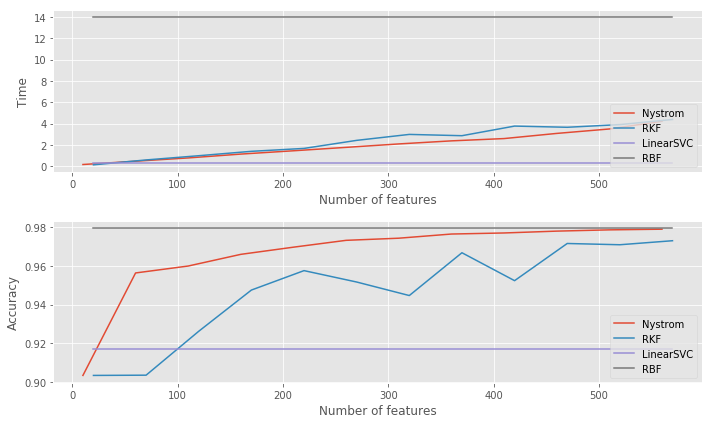

In [12]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

** Nous pouvons constater ici que les observations faites précédemment se confirment. Passé environ le rang 100, les méthodes de Nyström et Random Kernel Features deviennent plus performantes en précision que la méthode linéaire classique tout en restant raisonnablement rapides, bien que légèrement plus lentes que la SVM linéaire. 
La méthode de Nyström semble également plus stable et plus performante en précision que le RKF, tout en restant dans le même ordre de grandeur d'exécution. 
Enfin, nous observons également que passé le rang 500, la méthode de Nyström devient aussi précise que la SVM à noyau gaussien tout en restant près de trois fois plus rapide. 
Il semble donc que les méthodes de Nyström et des Random Kernel Features soient de bonnes alternatives aux méthodes à noyaux non linéaires lorsqu'un passage à l'échelle est nécessaire.**